Парсинг инфляции

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
from scipy.stats import bootstrap

In [24]:
data=pd.read_excel('/content/Питон данные.xlsx')
data=data[data['Регион']!='Российская Федерация']
data['Treat']=np.where((((data['Регион']=='Забайкальский край')|(data['Регион']=='Нижегородская область')|(data['Регион']=='Краснодарский край')|(data['Регион']=='Красноярский край')|(data['Регион']=='Орловская область')|(data['Регион']=='Владимирская область')|(data['Регион']=='Ростовская область'))&(data['Год']>=2013)),1,0)

In [25]:
def parse_inflation_data(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'class': 'inflation-tbl'})
    year_headers = []
    for th in table.find('thead').find_all('th')[1:]:
        if th.find('span'):
            year_headers.append(th.find('span').get('title').split('в ')[1].replace(' г.', ''))
        else:
            year_headers.append(th.text.strip())
    data = []
    for tr in table.find('tbody').find_all('tr'):
        region = tr.find('td', {'class': 'inflation-region-name'}).text.strip()
        years_data = [td.text.strip() if td.text.strip() else None
                     for td in tr.find_all('td', {'class': 'inflation-year'})]

        if any(years_data):
            row = {'Регион': region}
            for year, value in zip(year_headers, years_data):
                row[year] = value
            data.append(row)

    return pd.DataFrame(data)
urls = {
    '2010-2014': 'https://www.audit-it.ru/inform/inflation/inflation_regions.php?start_year=2010&end_year=2014',
    '2015-2019': 'https://www.audit-it.ru/inform/inflation/inflation_regions.php?start_year=2015&end_year=2019',
    '2020-2024': 'https://www.audit-it.ru/inform/inflation/inflation_regions.php'
}
dfs = []
for period, url in urls.items():
    print(f"Парсинг данных за {period}...")
    df = parse_inflation_data(url)
    dfs.append(df)

# Объединяем все данные
full_df = dfs[0]
for df in dfs[1:]:
    full_df = full_df.merge(df, on='Регион', how='outer')

years = sorted([col for col in full_df.columns if col != 'Регион'], key=lambda x: int(x))
full_df = full_df[['Регион'] + years]

full_df.replace('', None, inplace=True)

Парсинг данных за 2010-2014...
Парсинг данных за 2015-2019...
Парсинг данных за 2020-2024...


Подготовка данных

In [26]:
def clean_inflation_value(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        x = x.replace(' ', '').replace('%', '').replace(',', '.')
    try:
        return float(x)
    except (ValueError, TypeError):
        return np.nan

def prepare_inflation_df(df_infl):
    df = df_infl.copy()
    year_cols = [col for col in df.columns if str(col).isdigit() and 2000 <= int(col) <= 2100]

    for col in year_cols:
        df[col] = df[col].apply(clean_inflation_value)

    df_long = df.melt(id_vars=['Регион'],
                     value_vars=year_cols,
                     var_name='Год',
                     value_name='Инфляция')

    df_long['Год'] = pd.to_numeric(df_long['Год'], errors='coerce')
    df_long = df_long.dropna(subset=['Год'])
    df_long['Год'] = df_long['Год'].astype(int)
    df_long = df_long.sort_values(['Регион', 'Год'])

    def calculate_correct_ipc(group):
        if 2012 not in group['Год'].values:
            return group

        group = group.copy()
        base_2012 = group.loc[group['Год'] == 2012, 'Инфляция'].values[0]
        group.loc[group['Год'] == 2012, 'Индекс_ИПЦ'] = 100.0

        mask_post = (group['Год'] > 2012)
        group.loc[mask_post, 'Индекс_ИПЦ'] = (
            group.loc[mask_post, 'Инфляция'] / 100
        ).cumprod() * 100

        mask_pre = (group['Год'] < 2012)
        if mask_pre.any():
            infl_pre = group.loc[mask_pre, 'Инфляция'].iloc[::-1] / 100
            group.loc[mask_pre, 'Индекс_ИПЦ'] = 100 / infl_pre.cumprod()

        return group

    df_long = df_long.groupby('Регион', group_keys=False).apply(calculate_correct_ipc)
    return df_long

def adjust_financial_data(df_finance, df_infl):
    df_fin = df_finance.copy()
    df_infl = df_infl.copy()

    df_fin['Год'] = pd.to_numeric(df_fin['Год'], errors='coerce')
    df_fin = df_fin.dropna(subset=['Год'])
    df_fin['Год'] = df_fin['Год'].astype(int)

    df_merged = pd.merge(df_fin, df_infl, on=['Регион', 'Год'], how='left')

    df_merged['Реальные_доходы'] = df_merged['Доходы'] / (df_merged['Индекс_ИПЦ'] / 100)
    df_merged['Реальные_расходы'] = df_merged['Расходы'] / (df_merged['Индекс_ИПЦ'] / 100)

    if 'ЗП' in df_merged.columns:
        df_merged['ЗП'] = pd.to_numeric(df_merged['ЗП'], errors='coerce')
        df_merged['Реальная_ЗП'] = df_merged['ЗП'] / (df_merged['Индекс_ИПЦ'] / 100)

    return df_merged
df_infl_prepared = prepare_inflation_df(full_df)
data = adjust_financial_data(data, df_infl_prepared)
data = data.drop(columns=['Доходы', 'Расходы', 'ЗП', 'Индекс_ИПЦ', 'Инфляция'])

<ipython-input-26-4ec58eeaef30>:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_long = df_long.groupby('Регион', group_keys=False).apply(calculate_correct_ipc)


In [27]:
consumption = pd.read_excel('/content/электро питон.xlsx')
consumption['Регион.1'].replace('Город Москва столица Российской Федерации город федерального значения','г. Москва',inplace = True)
consumption['Регион.1'].replace('Город Санкт-Петербург город федерального значения','г. Санкт-Петербург',inplace = True)
consumption['Регион.1'].replace('Город федерального значения Севастополь','г. Севастополь',inplace = True)
consumption['Регион.1'].replace('Чувашская Республика - Чувашия','Чувашская Республика',inplace = True)
consumption = pd.melt(consumption, id_vars='Регион.1')
consumption.rename(columns={"Регион.1": "Регион", "variable": "Год",'value':'Электропотребление'}, inplace=True)
consumption['Год'] = consumption['Год'].astype(int)

<ipython-input-27-a6bd117ebb0c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  consumption['Регион.1'].replace('Город Москва столица Российской Федерации город федерального значения','г. Москва',inplace = True)
<ipython-input-27-a6bd117ebb0c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [28]:
treat = pd.merge(
    left=data,
    right=consumption,
    how='left',
    left_on=['Регион', 'Год'],
    right_on=['Регион', 'Год'],
)
treat.dropna(inplace=True)
treat['per_person_cons']=treat['Электропотребление']*1000/treat['Население']
treat['Площадь'].replace(',', '.', regex=True,inplace=True)
treat['Площадь'].replace(' ', '', regex=True,inplace=True)
#from google.colab import files
#treat.to_csv('treat.csv', encoding = 'utf-8-sig')
#files.download('treat.csv')

<ipython-input-28-09db9f5d819c>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  treat['Площадь'].replace(',', '.', regex=True,inplace=True)
<ipython-input-28-09db9f5d819c>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

Разведывательный анализ данных

In [29]:
treat.describe(include='all')

,Регион,Площадь,Население,Занятые,Фонды,Год,Treat,Реальные_доходы,Реальные_расходы,Реальная_ЗП,Электропотребление,per_person_cons
count,932,932.000000,932.000000,932.000000,9.320000e+02,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000
unique,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Белгородская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1892.953863,16759.090129,7361.050429,1.369372e+06,2017.517167,0.082618,18611.464958,13268.673997,54457.245670,1760.581330,104.502035
std,NaN,3455.033635,14692.278088,6140.547019,2.772735e+06,3.450544,0.275452,7643.730153,3901.730511,79236.094733,1746.392778,42.449727
min,NaN,31.000000,478.000000,307.000000,2.170000e+02,2012.000000,0.000000,8032.940257,4019.946310,11501.989495,21.900000,7.070370
25%,NaN,345.000000,7457.500000,3247.000000,4.075325e+04,2015.000000,0.000000,14810.983618,11005.542600,18039.004360,673.325000,81.798567
50%,NaN,715.000000,11836.000000,5197.000000,6.506490e+05,2018.000000,0.000000,16577.362020,12670.329730,21681.672442,1125.050000,99.391032
75%,NaN,1647.000000,23458.250000,10099.750000,1.565339e+06,2021.000000,0.000000,19862.209580,15203.268035,32122.018401,2439.425000,121.620331


In [30]:
treat.query('Treat==1').describe(include='all')

,Регион,Площадь,Население,Занятые,Фонды,Год,Treat,Реальные_доходы,Реальные_расходы,Реальная_ЗП,Электропотребление,per_person_cons
count,77,77.000000,77.000000,77.000000,7.700000e+01,77.000000,77.0,77.000000,77.000000,77.000000,77.000000,77.000000
unique,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Владимирская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,4436.571429,28383.363636,12637.883117,1.796264e+06,2018.000000,1.0,18026.504063,14144.694009,37637.405515,2823.738961,95.003365
std,NaN,8010.726633,18444.376344,7791.078065,2.247894e+06,3.183014,0.0,2672.926603,2746.793000,53044.812575,2085.229839,23.773544
min,NaN,247.000000,7003.000000,1640.000000,1.094000e+03,2013.000000,1.0,13810.765339,10246.180434,15002.703243,345.600000,10.280129
25%,NaN,291.000000,10904.000000,4770.000000,1.397000e+04,2015.000000,1.0,15432.174827,11517.328128,18705.899172,1070.300000,89.382904
50%,NaN,766.000000,28662.000000,14064.000000,9.216030e+05,2018.000000,1.0,18564.812699,14607.508481,20750.168258,2919.500000,98.263469
75%,NaN,4319.000000,41978.000000,19096.000000,2.786870e+06,2021.000000,1.0,20433.539441,15822.385759,25617.386966,3729.700000,107.261376


In [31]:
treat.query('Treat==0').describe(include='all')

,Регион,Площадь,Население,Занятые,Фонды,Год,Treat,Реальные_доходы,Реальные_расходы,Реальная_ЗП,Электропотребление,per_person_cons
count,855,855.000000,855.000000,855.000000,8.550000e+02,855.000000,855.0,855.000000,855.000000,855.000000,855.000000,855.000000
unique,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Белгородская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1663.879532,15712.225731,6885.826901,1.330926e+06,2017.473684,0.0,18664.145647,13189.780967,55972.014900,1664.834971,105.357470
std,NaN,2582.021906,13848.127439,5741.724563,2.813121e+06,3.472063,0.0,7938.837412,3981.111270,81032.282682,1681.317656,43.649605
min,NaN,31.000000,478.000000,307.000000,2.170000e+02,2012.000000,0.0,8032.940257,4019.946310,11501.989495,21.900000,7.070370
25%,NaN,347.000000,6913.500000,3097.500000,4.479400e+04,2014.000000,0.0,14738.942956,10957.718007,18017.424069,652.150000,81.524548
50%,NaN,662.000000,11525.000000,5089.000000,6.246790e+05,2017.000000,0.0,16516.000000,12639.875008,21840.748929,1095.500000,99.709817
75%,NaN,1647.000000,19783.500000,9319.500000,1.471726e+06,2020.000000,0.0,19690.771040,14997.059444,34007.511020,2166.150000,122.569289


In [32]:
treat.query('Treat==1')[['Электропотребление','per_person_cons']].describe(include='all')

,Электропотребление,per_person_cons
count,77.000000,77.000000
mean,2823.738961,95.003365
std,2085.229839,23.773544
min,345.600000,10.280129
25%,1070.300000,89.382904
50%,2919.500000,98.263469
75%,3729.700000,107.261376
max,9412.400000,161.744540


In [33]:
treat.query('Treat==0')[['Электропотребление','per_person_cons']].describe(include='all')

,Электропотребление,per_person_cons
count,855.000000,855.000000
mean,1664.834971,105.357470
std,1681.317656,43.649605
min,21.900000,7.070370
25%,652.150000,81.524548
50%,1095.500000,99.709817
75%,2166.150000,122.569289
max,11526.400000,452.452653


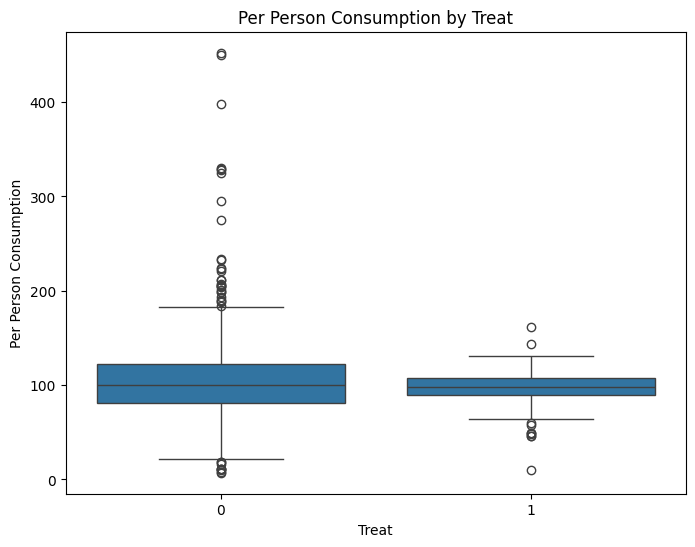

In [34]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Treat', y='per_person_cons', data=treat)
plt.title('Per Person Consumption by Treat')
plt.xlabel('Treat')
plt.ylabel('Per Person Consumption')
plt.show()

<Axes: xlabel='per_person_cons', ylabel='Count'>

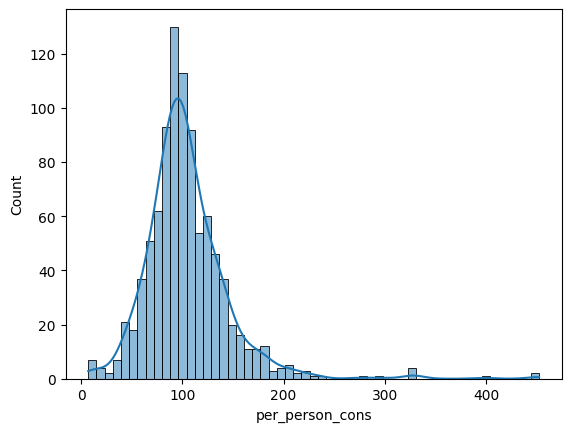

In [35]:
sns.histplot(data=treat, x='per_person_cons', kde=True)

<Axes: xlabel='per_person_cons', ylabel='Count'>

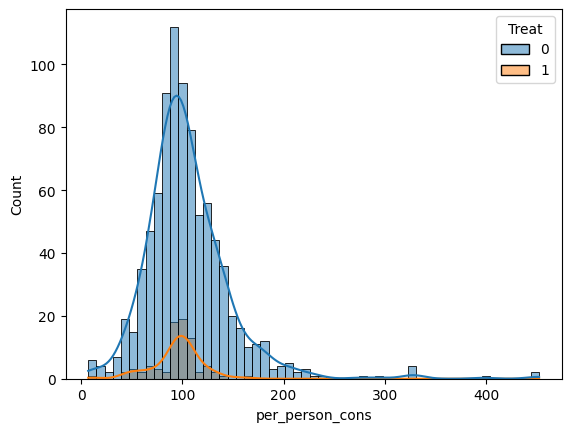

In [36]:
sns.histplot(data=treat, x='per_person_cons', kde=True, hue='Treat')

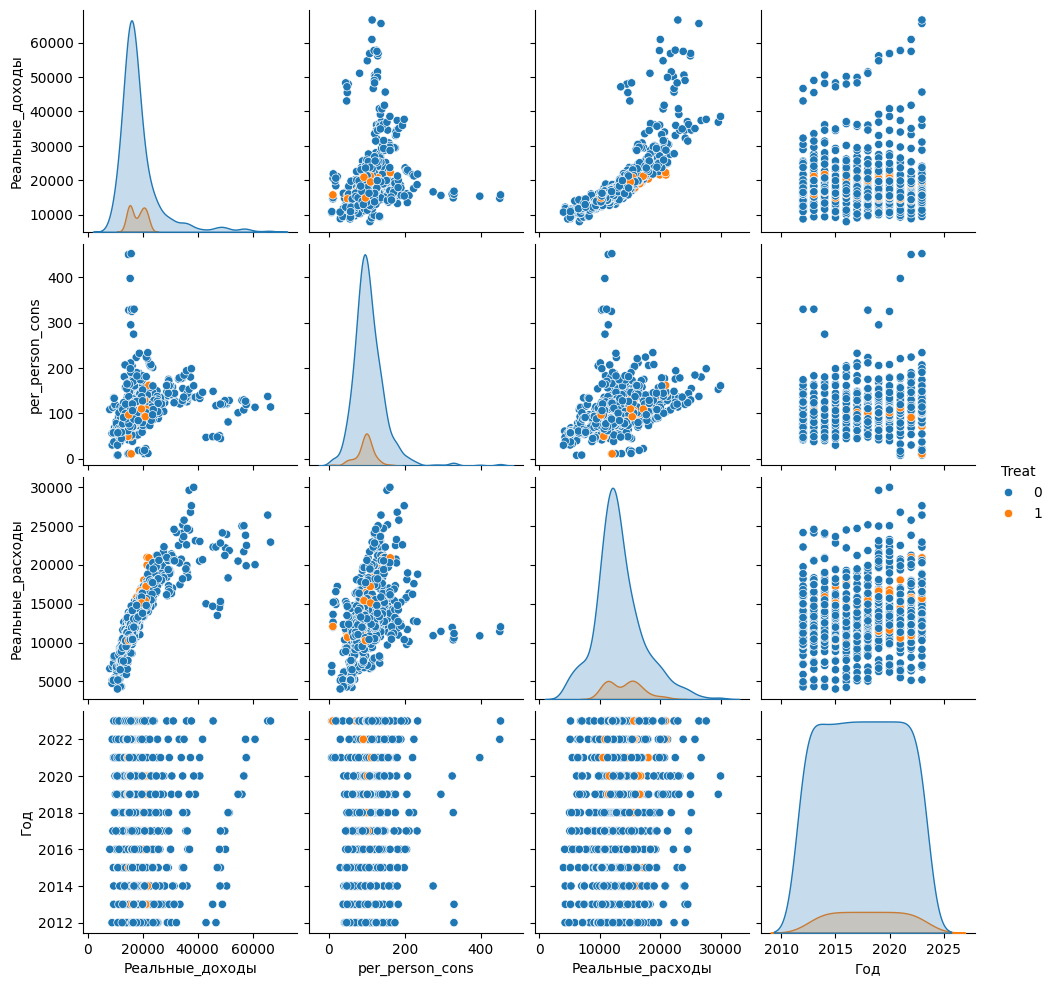

In [37]:
sns.pairplot(treat[['Реальные_доходы','per_person_cons', 'Реальные_расходы','Год', 'Treat']], hue='Treat')

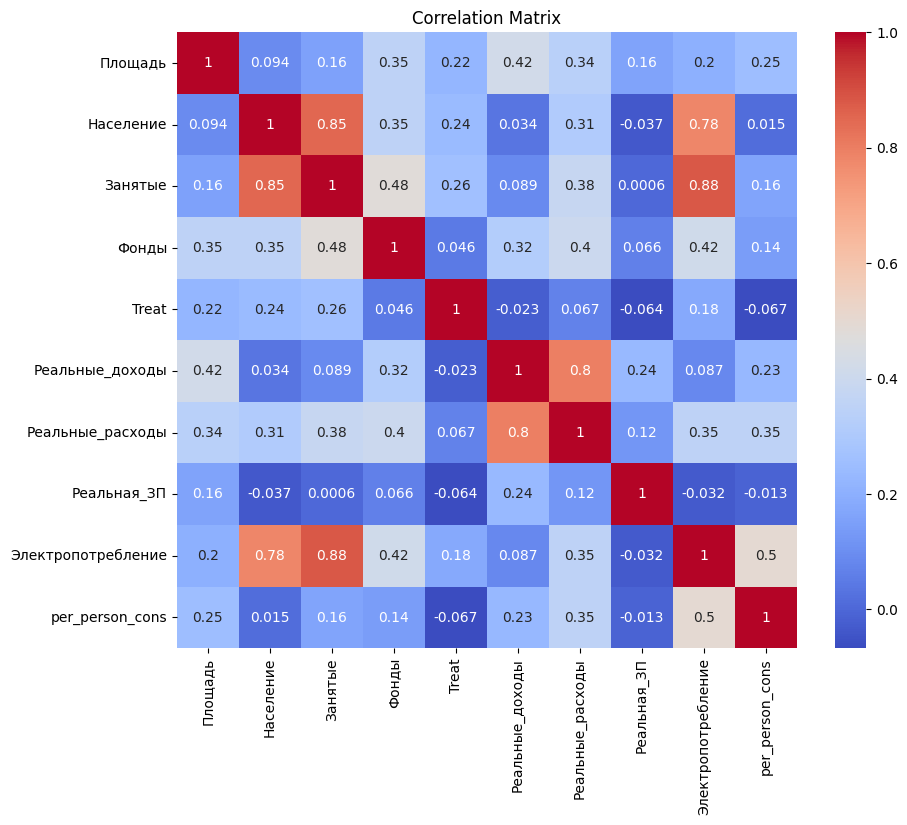

In [38]:
correlation_matrix = treat.drop(columns=['Регион', 'Год']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

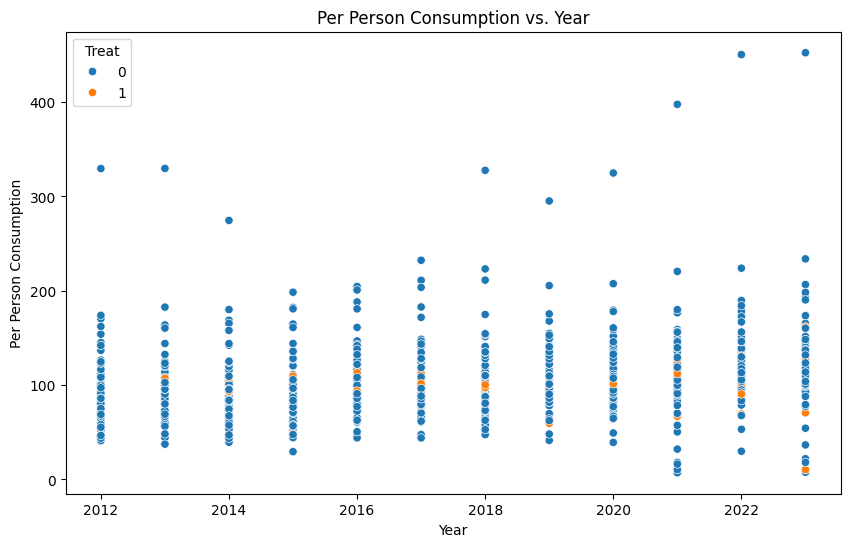

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Год', y='per_person_cons', data=treat, hue='Treat')
plt.title('Per Person Consumption vs. Year')
plt.xlabel('Year')
plt.ylabel('Per Person Consumption')
plt.show()

Построение модели

In [40]:
treat.drop(columns=['Электропотребление', 'Фонды'], inplace=True)
X=list(treat.columns)
X.remove('per_person_cons')
X.remove('Регион')
X.remove('Treat')
X.remove('Год')
y='per_person_cons'
treat[X]= treat[X].astype(float)
treat = treat.assign(**{f: (treat[f] - treat[f].mean())/treat[f].std() for f in X})

In [41]:
from sklearn.neighbors import KNeighborsRegressor
treated = treat[treat['Treat']==1]
untreated = treat[treat['Treat']==0]

tt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
tt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=tt0.predict(treated[X])),

    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=tt1.predict(untreated[X]))
])
from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated
treated_match_index = tt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
untreated_match_index = tt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

predicted = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=tt0.predict(treated[X]))

     # build the bias correction term
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    (untreated
     .assign(match=tt1.predict(untreated[X]))
     .assign(bias_correct=ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])))
])
np.mean((2*predicted["Treat"] - 1)*((predicted["per_person_cons"] - predicted["match"])-predicted["bias_correct"])) #ATE estimate

np.float64(-24.545981402973506)

In [42]:
#function for bootstrapping
def ATE(data):
    a=np.mean((2*data["Treat"] - 1)*((data["per_person_cons"] - data["match"])-data["bias_correct"]))
    return a

In [43]:
indices = np.arange(len(predicted))
data = (indices,)

def ATE(indices_subset):
    subset = predicted.iloc[indices_subset]
    return np.mean((2*subset["Treat"] - 1)*((subset["per_person_cons"] - subset["match"])-subset["bias_correct"]))

res = bootstrap(data, ATE, n_resamples=1000, confidence_level=0.95,
                vectorized=False)
results_table = [
    ["Статистика", "Значение"],
    ["Среднее значение ATE", f"{res.bootstrap_distribution.mean():.4f}"],
    ["Стандартная ошибка", f"{res.standard_error:.4f}"],
    ["Нижняя граница 95% ДИ", f"{res.confidence_interval.low:.4f}"],
    ["Верхняя граница 95% ДИ", f"{res.confidence_interval.high:.4f}"],
    ["Количество ресэмплов", 1000]
]

print(tabulate(results_table, headers="firstrow", tablefmt="grid"))

+------------------------+------------+
| Статистика             |   Значение |
+========================+============+
| Среднее значение ATE   |   -24.604  |
+------------------------+------------+
| Стандартная ошибка     |     1.3456 |
+------------------------+------------+
| Нижняя граница 95% ДИ  |   -27.1612 |
+------------------------+------------+
| Верхняя граница 95% ДИ |   -21.9395 |
+------------------------+------------+
| Количество ресэмплов   |  1000      |
+------------------------+------------+
